# Softmax回归

In [70]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import random

In [6]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="./data",train=True,transform=trans,download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data",train=False,transform=trans,download=True)

In [26]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols* scale, num_rows* scale)
    fig, ax = plt.subplots(num_rows,num_cols,figsize=figsize)
    axes = ax.flatten()
    for i,(ax, img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)

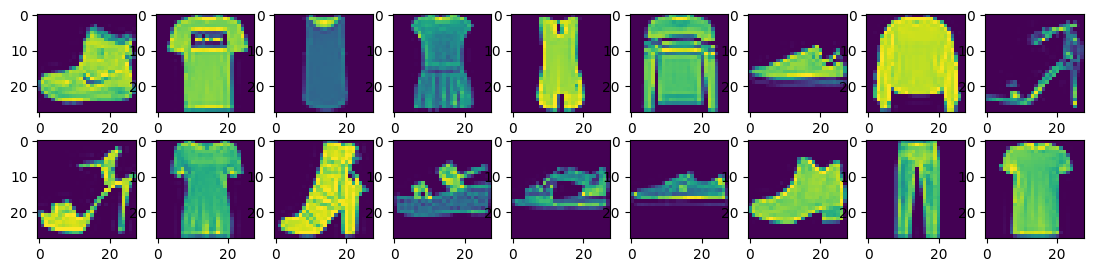

In [27]:
X,y = next(iter(data.DataLoader(mnist_train,batch_size=18)))
show_images(X.reshape(18,28,28),2,9,titles=get_fashion_mnist_labels(y))

In [40]:
batch_size = 256

train_iter = data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)
test_iter = data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=4)


In [41]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

In [46]:
def softmax(X):
    X_exp = torch.exp(X)
    return X_exp / X_exp.sum(1,keepdim=True)

In [47]:
X = torch.normal(0,1,(2,10))
X_prob = softmax(X)
X_prob,X_prob.sum(1)

(tensor([[0.1387, 0.0831, 0.0513, 0.2243, 0.1161, 0.0520, 0.1082, 0.1118, 0.0295,
          0.0849],
         [0.0980, 0.0692, 0.0444, 0.0118, 0.0364, 0.1587, 0.2391, 0.1685, 0.1524,
          0.0215]]),
 tensor([1.0000, 1.0000]))

In [63]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1,num_inputs)),W) + b)

In [49]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])


In [50]:
def accuracy(y_hat, y):
    if len(y_hat) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [51]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [53]:
def evaluate_accuracy(net,data_iter):
    metric = Accumulator(2)
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [61]:
def train_epoch(net,train_iter,loss,updater):
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        l.sum().backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [54]:
def train(net, train_iter, loss, num_epoches, updater):
    for epoch in range(num_epoches):
        train_metrics = train_epoch(net,train_iter,loss,updater)
        test_accuracy = evaluate_accuracy(net,test_iter)
        train_loss, train_acc = train_metrics
        print(f"Epoch: {epoch}, train_loss: {train_loss}, train_accuracy: {train_acc}, test_accuracy: {test_accuracy}")

In [68]:
def sgd(params_w, learning_rate, batch_size):
    with torch.no_grad():
        for param in params_w:
            param -= (learning_rate * param.grad / batch_size)
            param.grad.zero_()

def updater(batch_size):
    learning_rate = 0.1
    return sgd([W,b],learning_rate,batch_size)

In [69]:
num_epoches = 30

train(net,train_iter,cross_entropy,num_epoches, updater)

Epoch: 0, train_loss: 0.41086546929677326, train_accuracy: 0.8593333333333333, test_accuracy: 0.8427
Epoch: 1, train_loss: 0.40955520299275716, train_accuracy: 0.8598, test_accuracy: 0.8411
Epoch: 2, train_loss: 0.4091984664916992, train_accuracy: 0.8604333333333334, test_accuracy: 0.8304
Epoch: 3, train_loss: 0.4073880500793457, train_accuracy: 0.8600166666666667, test_accuracy: 0.8403
Epoch: 4, train_loss: 0.4074658552805583, train_accuracy: 0.8606166666666667, test_accuracy: 0.828
Epoch: 5, train_loss: 0.406495064163208, train_accuracy: 0.8606666666666667, test_accuracy: 0.8385
Epoch: 6, train_loss: 0.4054186306635539, train_accuracy: 0.8615666666666667, test_accuracy: 0.8408
Epoch: 7, train_loss: 0.4041972636540731, train_accuracy: 0.8613333333333333, test_accuracy: 0.8421
Epoch: 8, train_loss: 0.40332073027292886, train_accuracy: 0.8609833333333333, test_accuracy: 0.8271
Epoch: 9, train_loss: 0.403434264755249, train_accuracy: 0.8611, test_accuracy: 0.8413
Epoch: 10, train_loss: 0

Text(0.5, 1.0, 'Real Group: 8, Calculated Group: 8')

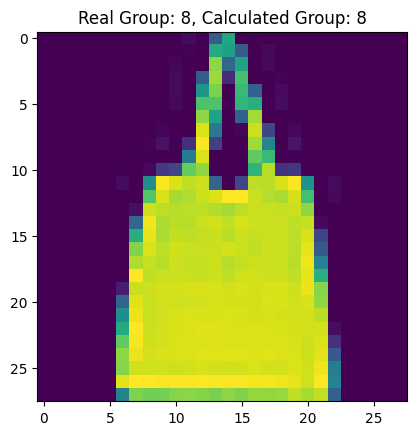

In [131]:
test_item = random.choice(mnist_test)
result = net(test_item[0])
fig, ax = plt.subplots()
ax.imshow(test_item[0].reshape((28,28)))
ax.set_title(f"Real Group: {test_item[1]}, Calculated Group: {result.argmax()}")